In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from clearml import Task, Logger

In [2]:
%env CLEARML_WEB_HOST=http://127.0.0.1:8080/
%env CLEARML_API_HOST=http://127.0.0.1:8008
%env CLEARML_FILES_HOST=http://127.0.0.1:8081
# First_credentials
%env CLEARML_API_ACCESS_KEY=BMPF1Z577Z5MCU1E7XKJVPL6QPY5FV
%env CLEARML_API_SECRET_KEY=aQNj3DL5ggBLWCqTFoPE3OISQYoaTAhWwX9ucw-HWFnpbNrOv7GcglX7n6puEdXbeSU

env: CLEARML_WEB_HOST=http://127.0.0.1:8080/
env: CLEARML_API_HOST=http://127.0.0.1:8008
env: CLEARML_FILES_HOST=http://127.0.0.1:8081
env: CLEARML_API_ACCESS_KEY=BMPF1Z577Z5MCU1E7XKJVPL6QPY5FV
env: CLEARML_API_SECRET_KEY=aQNj3DL5ggBLWCqTFoPE3OISQYoaTAhWwX9ucw-HWFnpbNrOv7GcglX7n6puEdXbeSU


In [3]:
task = Task.init(project_name="First_project", 
                 task_name="test_catboost_car_sales",
                 tags=['Model:Catboost'])

ClearML Task: created new task id=cc948d9d68174c1cb0865bfbd9c2b37f
2025-02-22 13:47:12,124 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: No module named 'nbconvert'
2025-02-22 13:47:12,128 - clearml.Repository Detection - WARNING - Please install nbconvert using "pip install nbconvert"
ClearML results page: http://127.0.0.1:8080/projects/40314023743f48d3a5524a64eb0e13d9/experiments/cc948d9d68174c1cb0865bfbd9c2b37f/output/log
2025-02-22 13:47:12,168 - clearml.Task - INFO - Storing jupyter notebook directly as code


In [4]:
log = Logger.current_logger()

In [5]:
current_year = datetime.now().year

## EDA и предобработка первого источника данных

In [6]:
data_first_source = pd.read_csv("CAR DETAILS FROM CAR DEKHO.csv")
data_first_source

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner
...,...,...,...,...,...,...,...,...
4335,Hyundai i20 Magna 1.4 CRDi (Diesel),2014,409999,80000,Diesel,Individual,Manual,Second Owner
4336,Hyundai i20 Magna 1.4 CRDi,2014,409999,80000,Diesel,Individual,Manual,Second Owner
4337,Maruti 800 AC BSIII,2009,110000,83000,Petrol,Individual,Manual,Second Owner
4338,Hyundai Creta 1.6 CRDi SX Option,2016,865000,90000,Diesel,Individual,Manual,First Owner


In [7]:
data_first_source.describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


In [8]:
data_first_source.describe(include=[object])

,name,fuel,seller_type,transmission,owner
count,4340,4340,4340,4340,4340
unique,1491,5,3,2,5
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner
freq,69,2153,3244,3892,2832


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'selling_price'}>],
       [<Axes: title={'center': 'km_driven'}>, <Axes: >]], dtype=object)

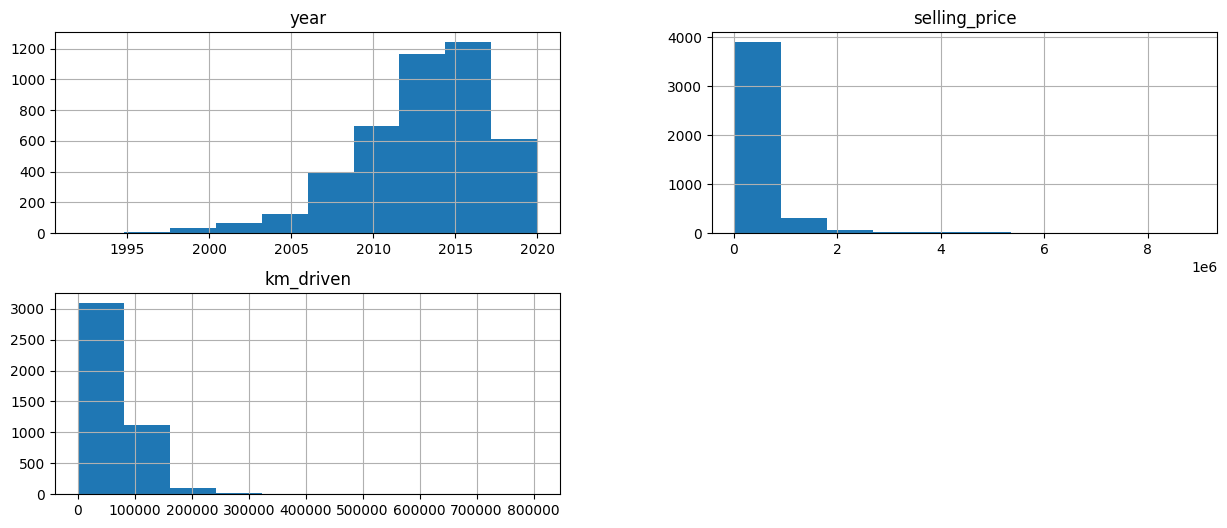

In [9]:
data_first_source.hist(figsize=(15,6))

In [10]:
object_columns_list = [x for x in data_first_source.columns if data_first_source[x].dtype=='object']

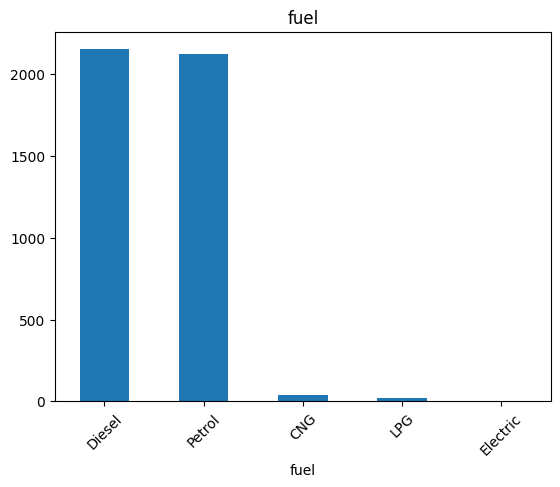

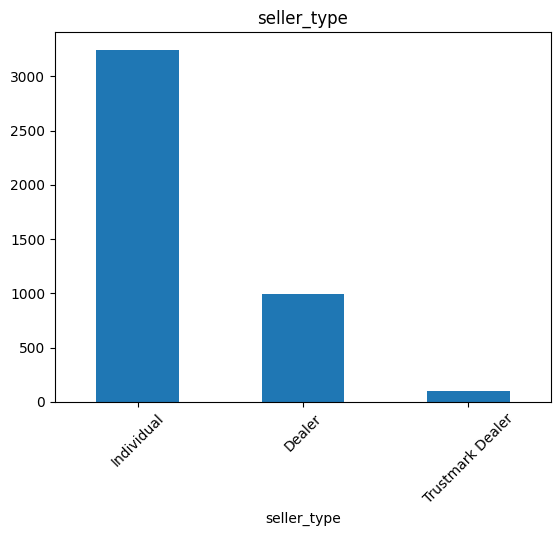

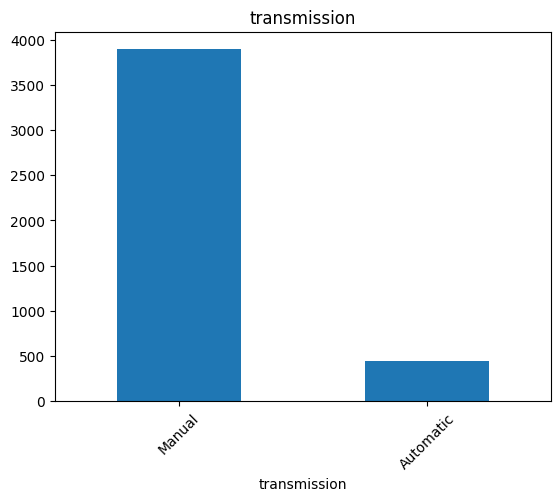

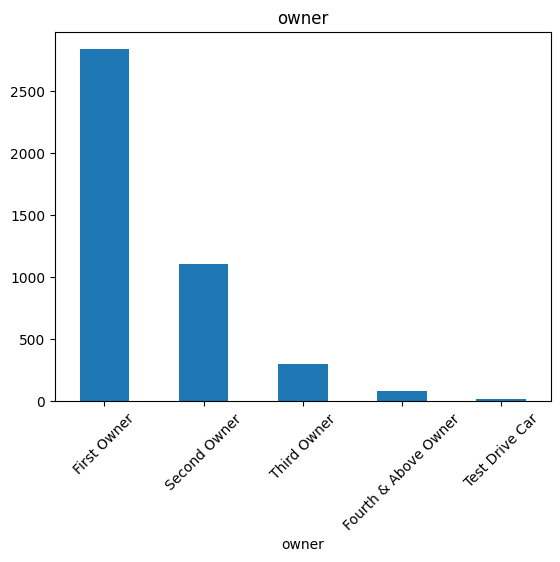

In [11]:
for i, column in enumerate(data_first_source[object_columns_list[1:]]):
    data_first_source[column].value_counts().plot(kind="bar").set_title(column)
    plt.xticks(rotation=45)
    plt.show()

In [12]:
print(f'NaN значения: {data_first_source.isnull().values.any()}')
print('')
print(f'Есть ли дубликаты?: {data_first_source.duplicated().values.any()}')

NaN значения: False

Есть ли дубликаты?: True


In [13]:
df_duplicated = data_first_source[data_first_source.duplicated(keep='first')]
df_duplicated

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
13,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
14,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
15,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
16,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
17,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner
...,...,...,...,...,...,...,...,...
4307,Mahindra Xylo H4,2019,599000,15000,Diesel,Individual,Manual,Third Owner
4308,Maruti Alto 800 LXI,2018,200000,35000,Petrol,Individual,Manual,First Owner
4309,Datsun GO Plus T,2017,350000,10171,Petrol,Dealer,Manual,First Owner
4310,Renault Duster 110PS Diesel RxL,2015,465000,41123,Diesel,Dealer,Manual,First Owner


In [14]:
df_duplicated = data_first_source[data_first_source.duplicated(keep=False)].query('name == "Hyundai Verna 1.6 SX"')
df_duplicated

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
15,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
528,Hyundai Verna 1.6 SX,2013,484999,65000,Diesel,Dealer,Manual,First Owner
4187,Hyundai Verna 1.6 SX,2013,484999,65000,Diesel,Dealer,Manual,First Owner


In [15]:
data_first_source = data_first_source.drop_duplicates(keep='first')
data_first_source = data_first_source.reset_index(drop=True)
data_first_source

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner
...,...,...,...,...,...,...,...,...
3572,Hyundai i20 Magna 1.4 CRDi (Diesel),2014,409999,80000,Diesel,Individual,Manual,Second Owner
3573,Hyundai i20 Magna 1.4 CRDi,2014,409999,80000,Diesel,Individual,Manual,Second Owner
3574,Maruti 800 AC BSIII,2009,110000,83000,Petrol,Individual,Manual,Second Owner
3575,Hyundai Creta 1.6 CRDi SX Option,2016,865000,90000,Diesel,Individual,Manual,First Owner


In [16]:
data_first_source.duplicated().values.any()

False

In [17]:
data_first_source.query("name == 'Maruti 800 AC'")

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
162,Maruti 800 AC,2007,95000,100000,Petrol,Individual,Manual,Second Owner
245,Maruti 800 AC,2002,65000,100000,Petrol,Individual,Manual,Second Owner
358,Maruti 800 AC,2000,60000,40000,Petrol,Individual,Manual,Third Owner
388,Maruti 800 AC,2007,105000,60000,Petrol,Individual,Manual,Second Owner
594,Maruti 800 AC,2012,180000,120000,Petrol,Individual,Manual,First Owner
1303,Maruti 800 AC,2002,80000,70000,Petrol,Individual,Manual,Second Owner
1558,Maruti 800 AC,2009,125000,50000,Petrol,Individual,Manual,Fourth & Above Owner
2673,Maruti 800 AC,2013,100000,80000,Petrol,Individual,Manual,First Owner
2705,Maruti 800 AC,2004,40000,69111,Petrol,Individual,Manual,Third Owner


## EDA и предобработка второго источника данных

In [18]:
data_second_source = pd.read_csv("cars_train.csv")
data_second_source

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6994,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
6995,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0
6996,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0
6997,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


In [19]:
data_second_source.describe()

,year,selling_price,km_driven,seats
count,6999.000000,6.999000e+03,6.999000e+03,6797.000000
mean,2013.818403,6.395152e+05,6.958462e+04,5.419008
std,4.053095,8.089419e+05,5.772400e+04,0.965767
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.700000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


In [20]:
data_second_source.describe(include=[object])

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,6999,6999,6999,6999,6999,6797,6797,6803,6796
unique,1924,4,3,2,5,386,120,316,419
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm
freq,116,3793,5826,6095,4587,197,885,330,468


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'selling_price'}>],
       [<Axes: title={'center': 'km_driven'}>,
        <Axes: title={'center': 'seats'}>]], dtype=object)

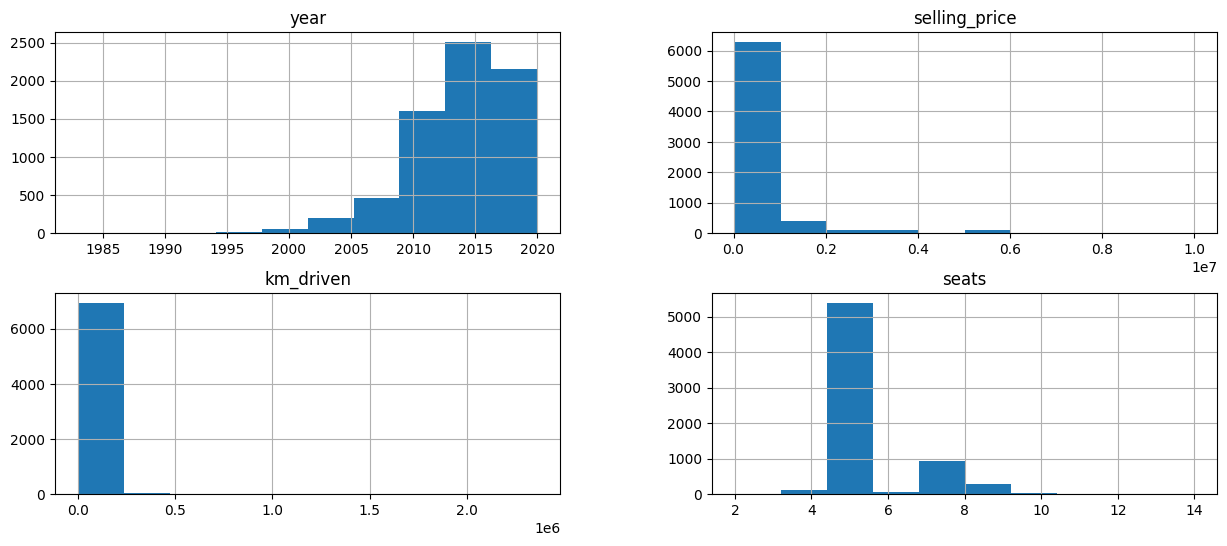

In [21]:
data_second_source.hist(figsize=(15,6))

In [22]:
print(f'NaN значения: {data_second_source.isnull().values.any()}')
print('')
print(f'Есть ли дубликаты?: {data_second_source.duplicated().values.any()}')

NaN значения: True

Есть ли дубликаты?: True


In [23]:
data_second_source[data_second_source.isna().any(axis=1)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
12,Maruti Swift 1.3 VXi,2007,200000,80000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
28,Fiat Palio 1.2 ELX,2003,70000,50000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
69,Tata Indica DLS,2003,50000,70000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
78,Maruti Swift VDI BSIV W ABS,2015,475000,78000,Diesel,Dealer,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
107,Maruti Swift VDI BSIV,2010,300000,120000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6764,Toyota Qualis Fleet A3,2000,200000,100000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
6889,Hyundai Santro LS zipPlus,2000,140000,50000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
6901,Hyundai Santro Xing XS eRLX Euro III,2006,145000,80000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
6949,Ford Figo Aspire Facelift,2017,580000,165000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN


In [24]:
df_duplicated = data_second_source[data_second_source.duplicated(keep='first')]
df_duplicated

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
254,Hyundai Grand i10 Sportz,2017,450000,35000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0
258,Maruti Swift VXI,2012,330000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,85.8 bhp,114Nm@ 4000rpm,5.0
324,Jaguar XE 2016-2019 2.0L Diesel Prestige,2017,2625000,9000,Diesel,Dealer,Automatic,First Owner,13.6 kmpl,1999 CC,177 bhp,430Nm@ 1750-2500rpm,5.0
325,Lexus ES 300h,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56 bhp,202Nm@ 3600-5200rpm,5.0
326,Jaguar XF 2.0 Diesel Portfolio,2017,3200000,45000,Diesel,Dealer,Automatic,First Owner,19.33 kmpl,1999 CC,177 bhp,430Nm@ 1750-2500rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6880,Renault Captur 1.5 Diesel RXT,2018,1265000,12000,Diesel,Individual,Manual,First Owner,20.37 kmpl,1461 CC,108.45 bhp,240Nm@ 1750rpm,5.0
6881,Maruti Ciaz Alpha Diesel,2019,1025000,32000,Diesel,Individual,Manual,First Owner,28.09 kmpl,1248 CC,88.50 bhp,200Nm@ 1750rpm,5.0
6989,Maruti Swift Dzire VDI,2015,625000,50000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
6997,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


In [25]:
df_duplicated = data_second_source[data_second_source.duplicated(keep=False)].query('name == "Lexus ES 300h"')
df_duplicated.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
118,Lexus ES 300h,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56 bhp,202Nm@ 3600-5200rpm,5.0
325,Lexus ES 300h,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56 bhp,202Nm@ 3600-5200rpm,5.0
358,Lexus ES 300h,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56 bhp,202Nm@ 3600-5200rpm,5.0
564,Lexus ES 300h,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56 bhp,202Nm@ 3600-5200rpm,5.0
926,Lexus ES 300h,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56 bhp,202Nm@ 3600-5200rpm,5.0


In [26]:
data_second_source = data_second_source.dropna()
data_second_source = data_second_source.drop_duplicates(keep='first')
data_second_source = data_second_source.reset_index(drop=True)
data_second_source

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92 kmpl,1086 CC,62.1 bhp,96.1Nm@ 3000rpm,5.0
5819,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.9 kmpl,998 CC,67.1 bhp,90Nm@ 3500rpm,5.0
5820,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
5821,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0


In [27]:
data_second_source[['mileage', 'engine', 'max_power']] = data_second_source[['mileage', 'engine', 'max_power']].apply(lambda x: pd.to_numeric(x.str.strip('kmpl CC bhp km/kg')))
data_second_source

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,113.75nm@ 4000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086,62.10,96.1Nm@ 3000rpm,5.0
5819,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.90,998,67.10,90Nm@ 3500rpm,5.0
5820,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197,82.85,113.7Nm@ 4000rpm,5.0
5821,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493,110.00,"24@ 1,900-2,750(kgm@ rpm)",5.0


In [28]:
data_second_source["torque_value"] = data_second_source["torque"].str.extract(r"^(\d{1,3}(?:,\d{3})*(?:\.\d+)?)")  # Выделяем Nm
data_second_source["max_torque_rpm"] = data_second_source["torque"].str.extract(r"(\d+(?:,\d{3})*(?:\.\d+)?)\D*$") # Выделяем rpm

# Убираем запятые и приводим к числовому типу
data_second_source["torque_value"] = data_second_source["torque_value"].str.replace(",", "", regex=True).astype(float)
data_second_source["max_torque_rpm"] = data_second_source["max_torque_rpm"].str.replace(",", "", regex=True).astype(float)

data_second_source = data_second_source.drop('torque', axis=1)

## Мердж двух источников данных

In [29]:
merged_dataset = pd.concat([data_first_source, data_second_source])
# Объединяем датасеты по 'name' и 'year' (оставляем все строки из df1)
#merged_dataset = data_first_source.merge(data_second_source[['name', 'year', 'mileage', 'engine', 'max_power', 'torque', 'seats']],
#                      on=['name', 'year'], how='left')
merged_dataset = merged_dataset.reset_index(drop=True)

In [30]:
merged_dataset

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque_value,max_torque_rpm
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN,NaN
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN,NaN
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN,NaN
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN,NaN
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9395,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086.0,62.10,5.0,96.1,3000.0
9396,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.90,998.0,67.10,5.0,90.0,3500.0
9397,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197.0,82.85,5.0,113.7,4000.0
9398,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493.0,110.00,5.0,24.0,2750.0


In [31]:
# Заполняем NaN-значения
nan_columns = merged_dataset.columns[merged_dataset.isna().any()].tolist()
for column in nan_columns:
    merged_dataset[column] = merged_dataset.groupby("name")[column].transform(lambda x: x.fillna(x.median()))
    if merged_dataset[column].isna().any():
        merged_dataset[column].fillna(merged_dataset[column].median(), inplace=True)

d:\car_sales_prediction\.venv\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

d:\car_sales_prediction\.venv\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

d:\car_sales_prediction\.venv\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

d:\car_sales_prediction\.venv\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

d:\car_sales_prediction\.venv\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

d:\car_sales_prediction\.venv\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

d:\car_sales_prediction\.venv\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

d:\car_sales_prediction\.venv\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

d:\car_sales_prediction\.venv\Lib\site-packages\numpy\li

In [32]:
#merged_dataset = merged_dataset.fillna(merged_dataset.select_dtypes(include='number').median())

In [33]:
merged_dataset

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque_value,max_torque_rpm
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner,16.10,796.0,37.00,4.0,59.0,2500.0
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner,18.90,1061.0,67.00,5.0,84.0,3500.0
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner,22.32,1582.0,126.32,5.0,259.8,2750.0
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner,22.70,799.0,53.64,5.0,72.0,4386.0
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner,25.80,1498.0,98.60,5.0,200.0,1750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9395,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086.0,62.10,5.0,96.1,3000.0
9396,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.90,998.0,67.10,5.0,90.0,3500.0
9397,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197.0,82.85,5.0,113.7,4000.0
9398,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493.0,110.00,5.0,24.0,2750.0


## Новые фичи

In [34]:
merged_dataset["fuel_consumption"] = 100 / merged_dataset["mileage"] # расход топлива (л на 100 км)

In [35]:
merged_dataset["power_per_litre"] = merged_dataset["max_power"] / (merged_dataset["engine"] / 1000) # мощность двигателя относительно объема

In [36]:
merged_dataset['km_per_year'] = merged_dataset['km_driven'] / (current_year - merged_dataset['year']) # средний пробег в год

In [37]:
merged_dataset['fuel_efficiency'] = merged_dataset['mileage'] / merged_dataset['km_driven'] # эффективность топлива - чем выше пробег на литр топлива, тем более эффективным является авто

In [38]:
merged_dataset['name'] = merged_dataset['name'].str.split().str[0]

In [39]:
merged_dataset

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque_value,max_torque_rpm,fuel_consumption,power_per_litre,km_per_year,fuel_efficiency
0,Maruti,2007,60000,70000,Petrol,Individual,Manual,First Owner,16.10,796.0,37.00,4.0,59.0,2500.0,6.211180,46.482412,3888.888889,0.000230
1,Maruti,2007,135000,50000,Petrol,Individual,Manual,First Owner,18.90,1061.0,67.00,5.0,84.0,3500.0,5.291005,63.147974,2777.777778,0.000378
2,Hyundai,2012,600000,100000,Diesel,Individual,Manual,First Owner,22.32,1582.0,126.32,5.0,259.8,2750.0,4.480287,79.848293,7692.307692,0.000223
3,Datsun,2017,250000,46000,Petrol,Individual,Manual,First Owner,22.70,799.0,53.64,5.0,72.0,4386.0,4.405286,67.133917,5750.000000,0.000493
4,Honda,2014,450000,141000,Diesel,Individual,Manual,Second Owner,25.80,1498.0,98.60,5.0,200.0,1750.0,3.875969,65.821095,12818.181818,0.000183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9395,Hyundai,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086.0,62.10,5.0,96.1,3000.0,5.580357,57.182320,11235.294118,0.000094
9396,Maruti,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.90,998.0,67.10,5.0,90.0,3500.0,5.291005,67.234469,4166.666667,0.000378
9397,Hyundai,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197.0,82.85,5.0,113.7,4000.0,5.405405,69.214703,9166.666667,0.000168
9398,Hyundai,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493.0,110.00,5.0,24.0,2750.0,5.952381,73.677160,6611.111111,0.000141


## Тестовое обучение модели

In [40]:
task.upload_artifact(name='dataset', artifact_object=merged_dataset)

True

In [41]:
# Явно определяем списки категориальных признаков
cat_features = [col for col in merged_dataset.columns if merged_dataset[col].dtype == 'object']
# Преобразуем категориальные признаки в тип 'category'
merged_dataset[cat_features] = merged_dataset[cat_features].apply(lambda x: x.astype('category'))

In [42]:
# Разделяем датасет на train (8000 строк) и test (1400 строк)
train_df = merged_dataset[:8000]
target_train = train_df['selling_price']
features_train = train_df.drop(['selling_price'], axis=1)
test_df = merged_dataset[8000:]
target_test = test_df['selling_price']
features_test = test_df.drop(['selling_price'], axis=1)

In [43]:
# Параметры модели
params = {
    'n_estimators': 100,
}
parameters_dict = Task.current_task().connect(params)

In [44]:
# Инициализируем модель с указанием категориальных признаков
model = CatBoostRegressor(cat_features=cat_features, **params)

In [45]:
model.fit(features_train, target_train)
preds = model.predict(features_test)

Learning rate set to 0.369716
0:	learn: 422993.5775619	total: 162ms	remaining: 16.1s
1:	learn: 360752.9646969	total: 201ms	remaining: 9.83s
2:	learn: 324134.2839178	total: 248ms	remaining: 8.03s
3:	learn: 276113.9710089	total: 286ms	remaining: 6.86s
4:	learn: 248907.8463903	total: 334ms	remaining: 6.34s
5:	learn: 231549.7184660	total: 382ms	remaining: 5.99s
6:	learn: 220686.4366753	total: 448ms	remaining: 5.96s
7:	learn: 212663.9065107	total: 500ms	remaining: 5.75s
8:	learn: 205474.5462597	total: 544ms	remaining: 5.5s
9:	learn: 201660.9981881	total: 586ms	remaining: 5.27s
10:	learn: 198552.4148116	total: 631ms	remaining: 5.1s
11:	learn: 195339.1522781	total: 677ms	remaining: 4.96s
12:	learn: 192735.5865779	total: 740ms	remaining: 4.95s
13:	learn: 189169.9957570	total: 785ms	remaining: 4.82s
14:	learn: 186580.2265051	total: 836ms	remaining: 4.74s
15:	learn: 184717.2241080	total: 882ms	remaining: 4.63s
16:	learn: 182723.7130643	total: 936ms	remaining: 4.57s
17:	learn: 182224.7594741	tota

In [46]:
mse = mean_squared_error(target_test, preds)
rmse = (np.sqrt(mean_squared_error(target_test, preds)))
mae = mean_absolute_error(target_test, preds)
r2 = r2_score(target_test, preds)
print("Оценка тестового множества модели CatBoost:")
print('MSE: {:.2f}'.format(mse))
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('R2: {:.2f}'.format(r2))

log.report_single_value(name="MSE", value=mse)
log.report_single_value(name="RMSE", value=rmse)
log.report_single_value(name="MAE", value=mae)
log.report_single_value(name="R2", value=r2)

Оценка тестового множества модели CatBoost:
MSE: 24960435938.28
RMSE: 157988.72
MAE: 79381.79
R2: 0.89


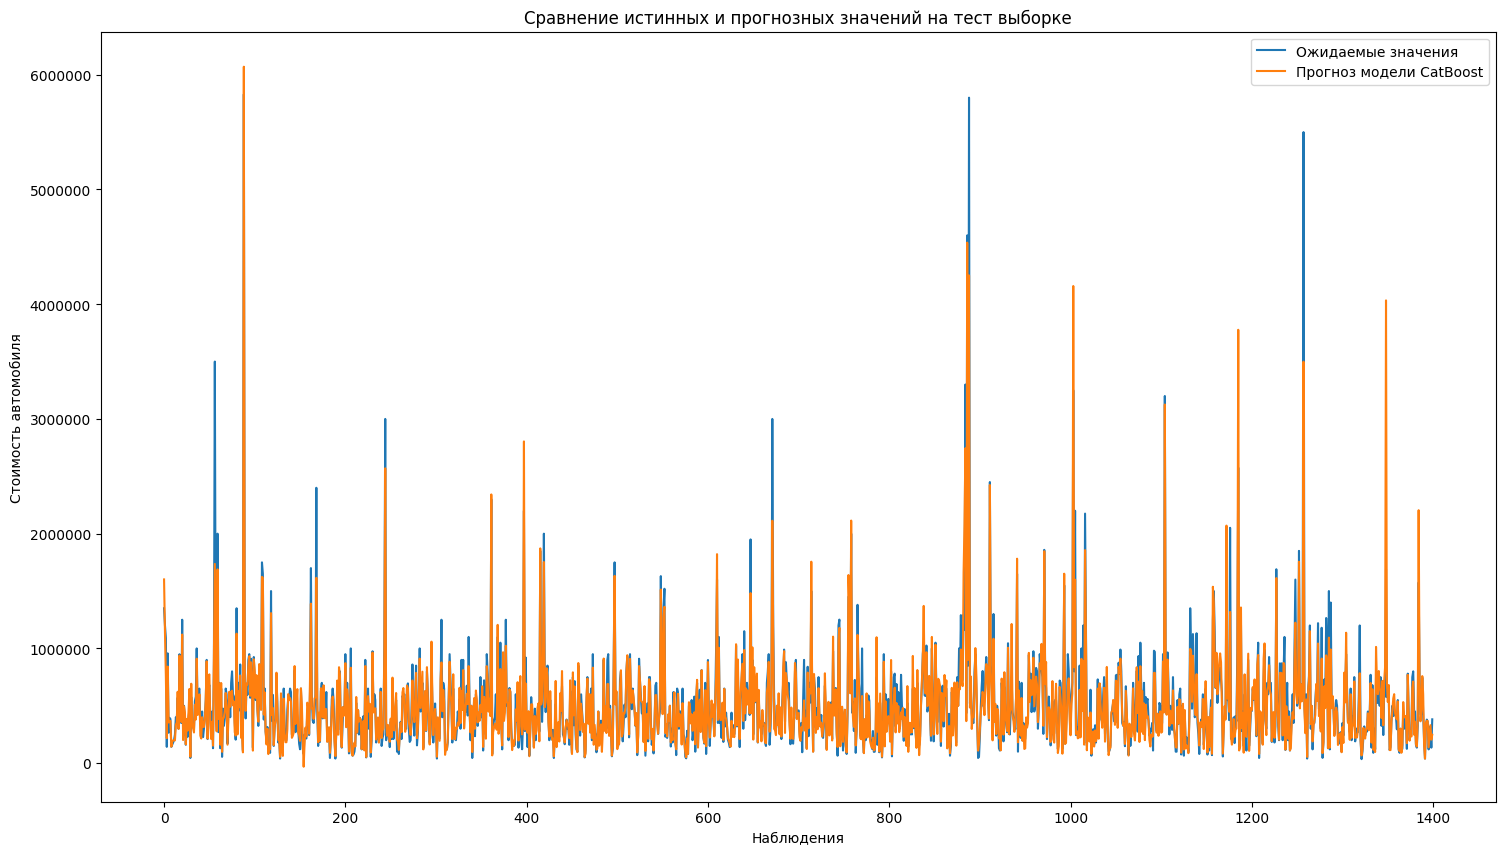

In [47]:
plt.figure(figsize=(18,10))
plt.title("Сравнение истинных и прогнозных значений на тест выборке")
plt.plot(target_test.values, label = 'Ожидаемые значения')
plt.plot(preds, label = 'Прогноз модели CatBoost')
plt.xlabel('Наблюдения')
plt.ylabel('Стоимость автомобиля')
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [48]:
importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=features_train.columns).sort_values()

d:\car_sales_prediction\.venv\Lib\site-packages\clearml\utilities\plotlympl\renderer.py:210: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



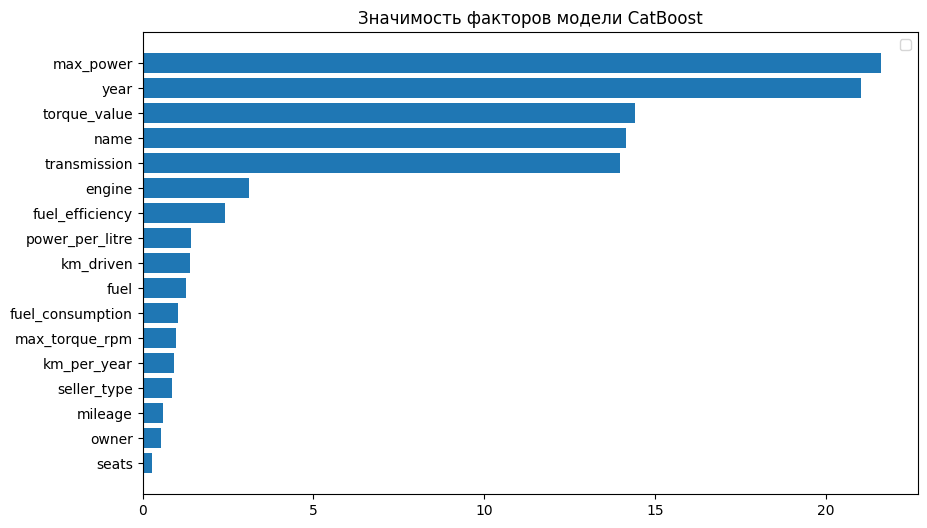

In [49]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('Значимость факторов модели CatBoost')
plt.show()

In [50]:
joblib.dump(model, "./model.pkl")

2025-02-22 13:47:27,364 - clearml.frameworks - INFO - Found existing registered model id=e556bb6b8c7040e5a75073f743c5277c [d:\car_sales_prediction\notebooks\model.pkl] reusing it.


['./model.pkl']

In [51]:
task.upload_artifact(name='car_sales_model_v2', artifact_object=model)

True

In [52]:
task.close()